<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3 

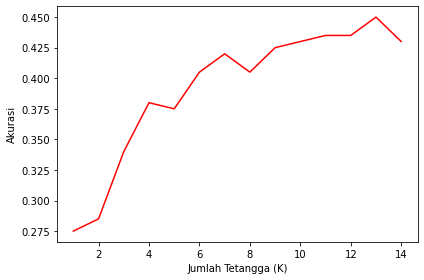

Akurasi terbaik adalah:  0.45  dengan nilai k = 13


In [32]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_021a87e05013461c90578e71cd237fb4 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_021a87e05013461c90578e71cd237fb4 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_021a87e05013461c90578e71cd237fb4 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='09YU4dpfFvJnZ4CeGFEfzHH0Tm_oae1skuWsS896DJQh',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_021a87e05013461c90578e71cd237fb4)

body = client_021a87e05013461c90578e71cd237fb4.get_object(Bucket='dicoding-donotdelete-pr-omfn50ikosuvlv',Key='german_credit_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head(10)

df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()
df.info()

#menangani missing values pada saving accounts dan checking accounts
df['Saving accounts'].fillna('little', inplace=True) #little digunakan untuk menyesuaikan dgn nilai terbanyak pada kolom tersebut
df['Checking account'].fillna('little', inplace=True)
df.info()

#definisikan fitur dan target
df_feature = df.drop('Purpose', axis=1)
df_target = df['Purpose']

#ubah tipe data menjadi kategori
df_feature[['Sex', 'Housing', 'Saving accounts', 'Checking account']] = df_feature[['Sex', 'Housing', 'Saving accounts', 'Checking account']].astype('category')
df_feature[['Sex', 'Housing', 'Saving accounts', 'Checking account']].info()


#aplikasikan fungsi catcodes untuk encoding
df_feature['Sex'] = df_feature['Sex'].cat.codes
df_feature['Housing'] = df_feature['Housing'].cat.codes
df_feature['Saving accounts'] = df_feature['Saving accounts'].cat.codes
df_feature['Checking account'] = df_feature['Checking account'].cat.codes
df_feature.tail()


#normalisasi data
x = StandardScaler().fit(df_feature).transform(df_feature.astype(float))
x[:5]

y = df_target
targ = y[:5]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
print('Train set: ', x_train.shape, y_train.shape)
print('Test set: ', x_test.shape, y_test.shape)


#modelling
k=5
model_knn = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)

#menguji model dengan data testing
y_predict = model_knn.predict(x_test)
print(y_predict[:5])
print(y_test[:5])

#mengevaluasi dgn melihat akurasinya
print('Akurasi train set ', accuracy_score(y_train,model_knn.predict(x_train)))
print('Akurasi test set: ', accuracy_score(y_test, y_predict))

#mencari nilai K terbaik
ks=15
mean_acc = np.zeros((ks-1))
for n in range(1, ks):
    model_knn = KNeighborsClassifier(n_neighbors = n).fit(x_train, y_train)
    y_predict = model_knn.predict(x_test)
    
    mean_acc[n-1] = accuracy_score(y_test, y_predict)
mean_acc

#visualisasikan data
plt.plot(range(1,ks), mean_acc, 'r')
plt.ylabel('Akurasi')
plt.xlabel('Jumlah Tetangga (K)')
plt.tight_layout()
plt.show()

print('Akurasi terbaik adalah: ', mean_acc.max(), ' dengan nilai k =', mean_acc.argmax()+1)